Import classes

In [30]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
import crossbar

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np
#Memtorch
import memtorch
#pandas
import pandas as pd
#Others
import copy

Load Dataset

name: X_test
shape: (640, 23, 2625)
-----------------------
name: X_train
shape: (640, 23, 2473)
-----------------------
name: clip_sizes_test
shape: (2, 135)
-----------------------
name: clip_sizes_train
shape: (2, 133)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2625)
-----------------------
name: sel_win_nums_train
shape: (1, 2473)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2625)
-----------------------
name: y_train
shape: (1, 2473)
-----------------------
print sample EGG signal from one node:


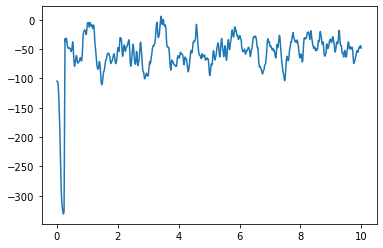

In [31]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_253.mat' #264 253 620
variables = load_patient_data(filepath, verbose = True)

In [32]:
#OPTIONAL: Shuffle the dataset
indices = np.load("datasets/indices_253.npy")# load shuffled indices
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, indices = indices, print_summary = True)

X_train: (640, 23, 2549)
X_test: (640, 23, 2549)
y_train: (1, 2549) Positive labes: 262.0
y_test: (1, 2549) Positive labes: 259.0


In [33]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

In [7]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

Load Models

--------data manager successfully initialized--------


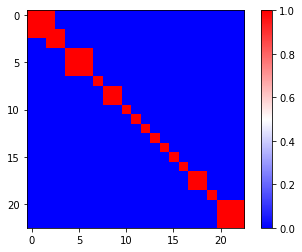

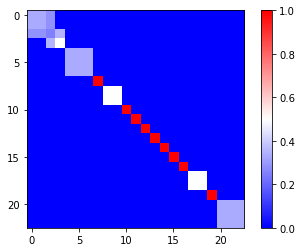

device set to cpu
device set to cpu


In [34]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
n = 3.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train
A = create_DAD(Araw)
GCNmodel, GCNoptimizer = GCNutil.load_model(GCNutil.load_ckp("models/GCN253_1.pt"), device_name ='cpu' )
MLPGCNmodel, MLPGCNoptimizer = MLP.load_model(MLP.load_ckp("models/MLPGCN253_1.pt"), A, device_name ='cpu' )

In [35]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [37]:
#ideal accuracy:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPGCNmodel, sim_all["GCN_test"], dm, threshold = t)

device set to cpu
threshold: 0.05  validation loss: 0.1465 F1 accuracy 0.531 Precision accuracy 0.372 Recall accuracy 0.923 AUC accuracy: 0.954
device set to cpu
threshold: 0.1  validation loss: 0.1465 F1 accuracy 0.598 Precision accuracy 0.449 Recall accuracy 0.892 AUC accuracy: 0.954
device set to cpu
threshold: 0.15  validation loss: 0.1465 F1 accuracy 0.651 Precision accuracy 0.521 Recall accuracy 0.869 AUC accuracy: 0.954
device set to cpu
threshold: 0.2  validation loss: 0.1465 F1 accuracy 0.681 Precision accuracy 0.572 Recall accuracy 0.842 AUC accuracy: 0.954
device set to cpu
threshold: 0.25  validation loss: 0.1465 F1 accuracy 0.698 Precision accuracy 0.607 Recall accuracy 0.822 AUC accuracy: 0.954
device set to cpu
threshold: 0.3  validation loss: 0.1465 F1 accuracy 0.709 Precision accuracy 0.643 Recall accuracy 0.792 AUC accuracy: 0.954
device set to cpu
threshold: 0.35  validation loss: 0.1465 F1 accuracy 0.729 Precision accuracy 0.681 Recall accuracy 0.784 AUC accuracy: 0

Crossbar (MLP)

In [40]:
cb_size = 512 #MLPGCNmodel.flatten(sim_all["GCN_train"]).shape[1]
print(cb_size)
device_params = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": cb_size,
                 "n": cb_size,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}


276


In [42]:
import torch
import crossbar
import numpy as np
import random
import os
import time
from tqdm import tqdm

# This testbench tries out a 100 matrices and vectors to multiply.

device_params = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": cb_size,
                 "n": cb_size,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "linear",
                 "viability": 0.05,
                 "device_resolution": 6
}

cb = crossbar.crossbar(device_params)

seed = 12
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

max_rows = device_params["m"] // 2
max_cols = device_params["n"]

test_num = 10

matrices = [torch.randint(-10, 10, (max_rows, max_cols)) for _ in range(test_num)]
vectors = [torch.randint(-10, 10, (max_cols, 1)) for _ in range(test_num)]


cb_time, t_time, error = 0.0, 0.0, 0.0
for matrix, vector in tqdm(zip(matrices, vectors)):
    cb.clear()
    ticket = cb.register_linear(torch.transpose(matrix,0,1))

    start_time = time.time()
    output = ticket.vmm(vector, v_bits=4)
    cb_time += time.time() - start_time

    start_time = time.time()
    target = matrix.matmul(vector)
    t_time += time.time() - start_time

    error += torch.norm(target - output) / torch.norm(matrix.double())

print("Average crossbar vmm time:", cb_time / test_num, "s")
print("Average torch vmm time:", t_time / test_num, "s")
print("Average relative error:", error / test_num)

10it [02:14, 13.49s/it]

Average crossbar vmm time: 11.011567163467408 s
Average torch vmm time: 0.0 s
Average relative error: tensor(5.8507, dtype=torch.float64)
